# pol dataset 

In [1]:
# Imports
import numpy as np
import pandas as pd

# Opendataval
from opendataval.dataloader import Register, DataFetcher, mix_labels, add_gauss_noise
from opendataval.dataval import (
    AME,
    DVRL,
    BetaShapley,
    DataBanzhaf,
    DataOob,
    DataShapley,
    InfluenceFunctionEval,
    KNNShapley,
    LavaEvaluator,
    LeaveOneOut,
    RandomEvaluator,
    RobustVolumeShapley,
)

from opendataval.experiment import ExperimentMediator

from opendataval.model.api import ClassifierSkLearnWrapper
from sklearn.ensemble import GradientBoostingClassifier

import warnings
warnings.filterwarnings("ignore")

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


## [Step 1] Set up an environment
`ExperimentMediator` is a fundamental concept in establishing the `opendataval` environment. It empowers users to configure hyperparameters, including a dataset, a type of synthetic noise, and a prediction model. With  `ExperimentMediator`, users can effortlessly compute various data valuation algorithms.

The following code cell demonstrates how to set up `ExperimentMediator` with a pre-registered dataset and a prediction model.
- Dataset: pol
- Model: sklearn's support vector machine
- Metric: Classification accuracy

In [2]:
# Set up hyperparameters
dataset_name = "pol"
train_count, valid_count, test_count = 1000, 100, 300
noise_rate = 0.2
noise_kwargs = {'noise_rate': noise_rate}
model_name = "sklogreg"
metric_name = "accuracy"

fetcher = DataFetcher.setup(
    dataset_name=dataset_name,
    cache_dir="../data_files/",  
    force_download=False,
    train_count=train_count,
    valid_count=valid_count,
    test_count=test_count,
    add_noise=mix_labels,
    noise_kwargs=noise_kwargs
)

### [Step 1-2] Set up a prediction model
Next is to set up a prediction model. With `ClassifierSkLearnWrapper` and `RegressionSkLearnWrapper`, any `sklearn` models can be utilized as a prediction model. The following code uses a random forest classifier `GradientBoostingClassifier` with custom parameters. 

In [3]:
# model paramters for GradientBoostingClassifier can be applied as follows.
pred_model = ClassifierSkLearnWrapper(GradientBoostingClassifier, 
                                      fetcher.label_dim[0],
                                      loss='log_loss', 
                                      learning_rate=0.05, 
                                      n_estimators=200,)

# We can check parameters with the following codes.
print('learning_rate: ', pred_model.model.get_params()['learning_rate'])
print('n_estimators: ', pred_model.model.get_params()['n_estimators'])

learning_rate:  0.05
n_estimators:  200


### [Step 1-3] Combining all 
- Combining [Step 1-1] and [Step 1-2] with `ExperimentMediator`

In [4]:
exper_med = ExperimentMediator(fetcher, pred_model)

## [Step 2] Compute data values
`opendataval` provides various state-of-the-art data valuation algorithms. `ExperimentMediator.compute_data_values()` computes data values.

In [5]:
data_evaluators = [ 
    RandomEvaluator(),
    LeaveOneOut(), # leave one out
    InfluenceFunctionEval(num_models=1000), # influence function
#     DVRL(rl_epochs=2000), # Data valuation using Reinforcement Learning
    KNNShapley(k_neighbors=valid_count), # KNN-Shapley
#     DataShapley(gr_threshold=1.05, mc_epochs=300, cache_name=f"cached"), # Data-Shapley
#     BetaShapley(gr_threshold=1.05, mc_epochs=300, cache_name=f"cached"), # Beta-Shapley
#     DataBanzhaf(num_models=1000), # Data-Banzhaf
#     AME(num_models=1000), # Average Marginal Effects
    DataOob(num_models=1000), # Data-OOB
    LavaEvaluator(),
#     RobustVolumeShapley(mc_epochs=300)
]

In [6]:
%%time
# compute data values.
exper_med = exper_med.compute_data_values(data_evaluators=data_evaluators)

Elapsed time RandomEvaluator(): 0:00:00.002421


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:19<00:00,  2.63it/s]


Elapsed time LeaveOneOut(): 0:06:20.297019


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [05:04<00:00,  3.29it/s]


Elapsed time InfluenceFunctionEval(num_models=1000): 0:05:04.221361


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:00<00:00, 11387.34it/s]


Elapsed time KNNShapley(k_neighbors=100): 0:00:00.118800


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [06:06<00:00,  2.73it/s]


Elapsed time DataOob(num_models=1000): 0:06:06.724262


Elapsed time LavaEvaluator(): 0:00:00.111148
CPU times: user 17min 23s, sys: 593 ms, total: 17min 23s
Wall time: 17min 31s


## [Step 3] Evaluate data values

In [7]:
from opendataval.experiment.exper_methods import (
    discover_corrupted_sample,
    noisy_detection,
    remove_high_low,
    save_dataval
)
from matplotlib import pyplot as plt

# Saving the results
output_dir = f"../tmp/{dataset_name}_{noise_rate=}/"
exper_med.set_output_directory(output_dir)
output_dir

'../tmp/pol_noise_rate=0.2/'

### Noisy data detection 
- `noisy_detection` performs the noisy data detection task and evaluates the F1-score of each data valuation algorithm's prediction. The higher, the better.  
  - noisy data: mislabeled data

In [8]:
exper_med.evaluate(noisy_detection, save_output=True)

,kmeans_f1
DataOob(num_models=1000),0.841163
InfluenceFunctionEval(num_models=1000),0.292467
KNNShapley(k_neighbors=100),0.430508
LavaEvaluator(),0.062992
LeaveOneOut(),0.278834
RandomEvaluator(),0.276074


### Discover noisy samples
- `discover_corrupted_sample` visualizes how well noisy data points are identified when a fraction of dataset is inspected. 

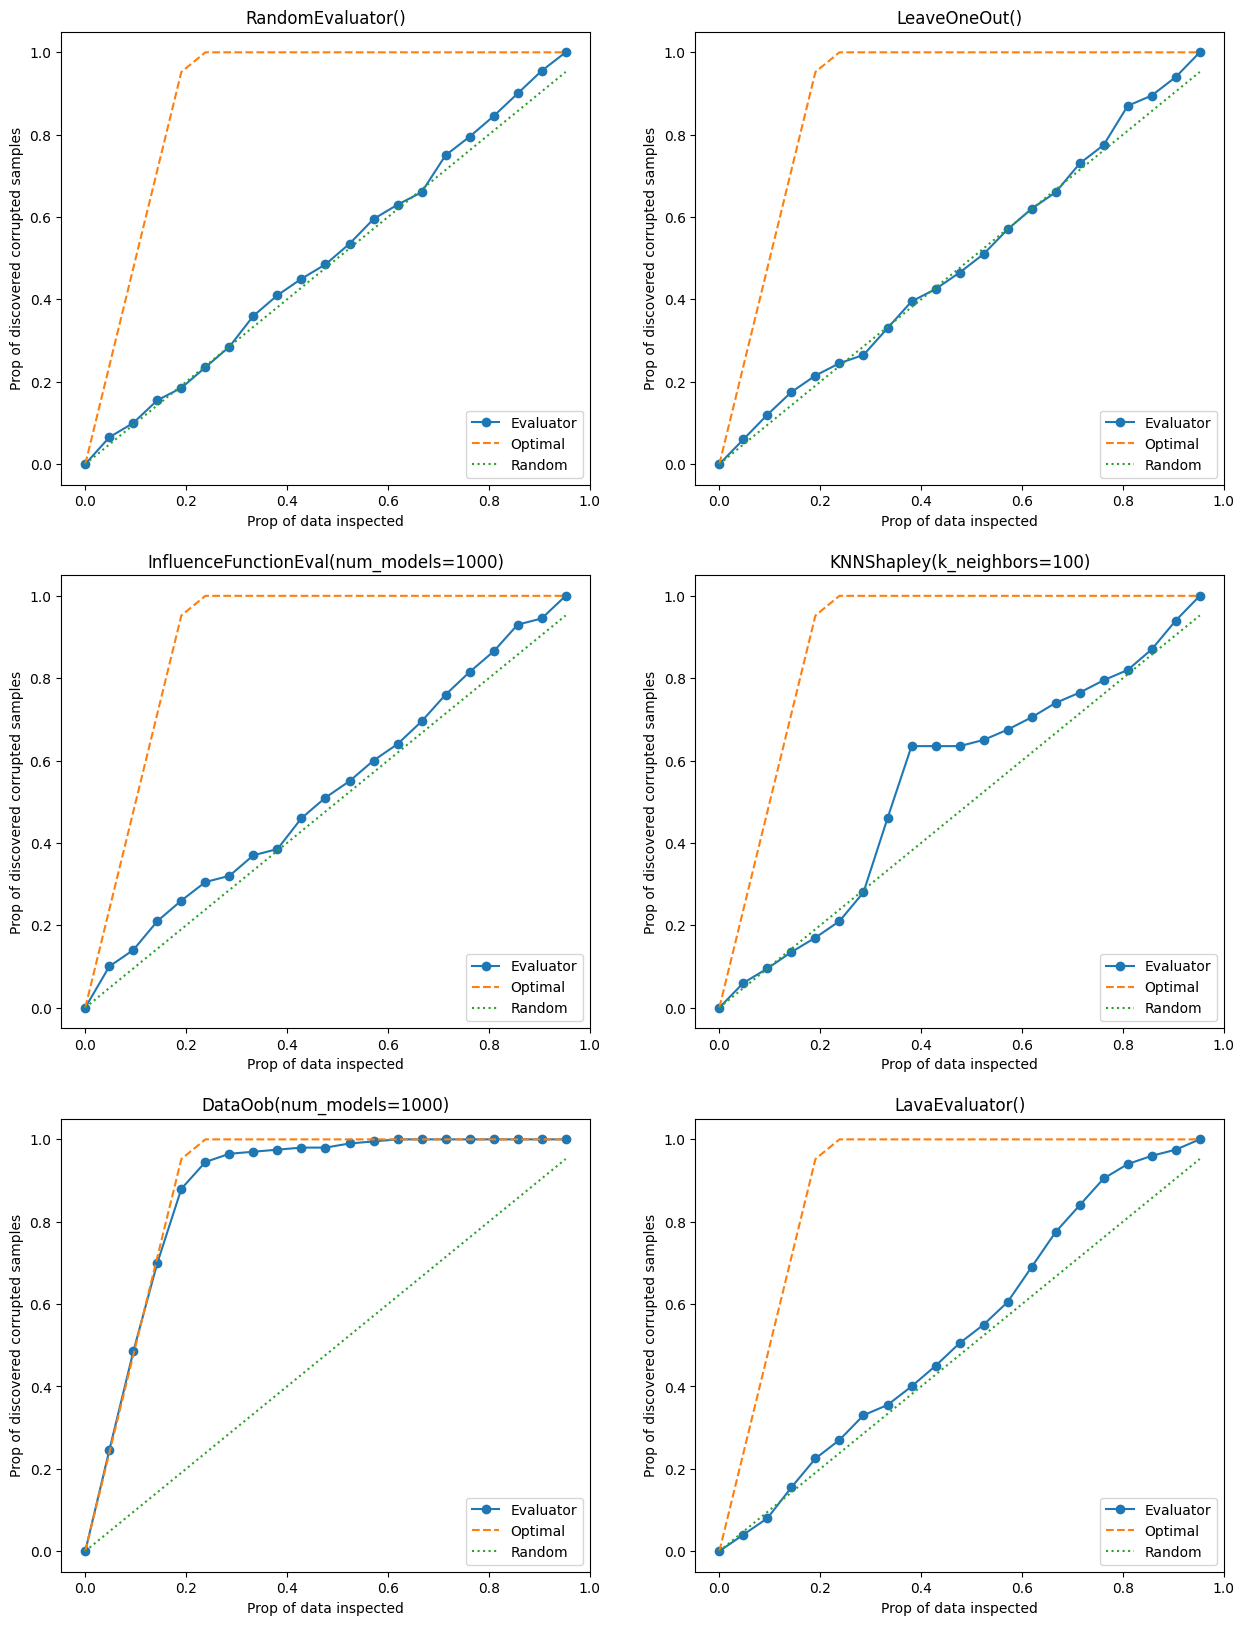

In [9]:
fig = plt.figure(figsize=(15, 20))
_, fig = exper_med.plot(discover_corrupted_sample, fig, col=2, save_output=True)

### Point removal experiment
- `remove_high_low` performs the point removal experiment. Each data valution algorithm, it provides two curves: one is removing data in a descending order (orange), the other is in an ascending order (blue). As for the orange (resp. blue) curve, the lower (resp. upper), the better. 

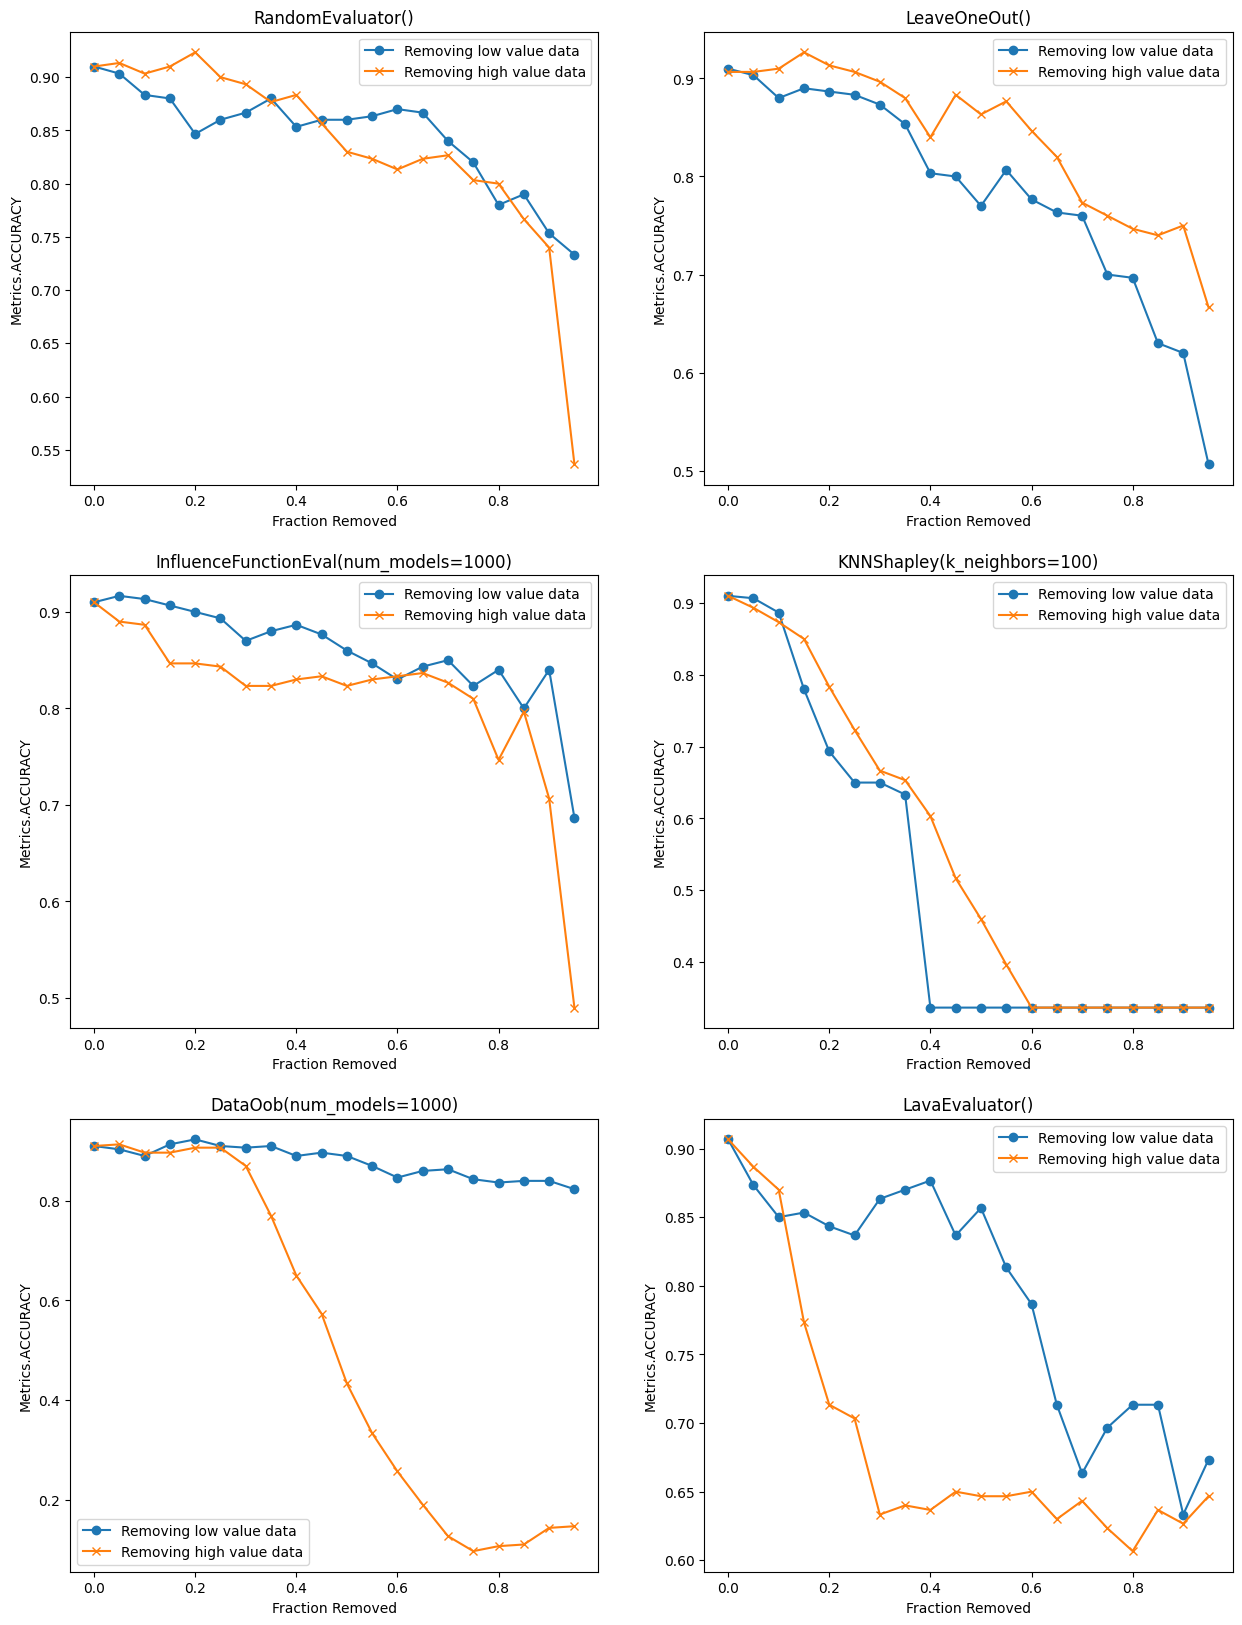

In [10]:
fig = plt.figure(figsize=(15, 20))
df_resp, fig = exper_med.plot(remove_high_low, fig, col=2, save_output=True)

In [11]:
df_resp # it provides complete information for generating point-removal experiment figures.

,remove_least_influential_first_Metrics.ACCURACY,remove_most_influential_first_Metrics.ACCURACY,axis
RandomEvaluator(),0.91,0.91,0.0
RandomEvaluator(),0.903333,0.913333,0.05
RandomEvaluator(),0.883333,0.903333,0.1
RandomEvaluator(),0.88,0.91,0.15
RandomEvaluator(),0.846667,0.923333,0.2
...,...,...,...
LavaEvaluator(),0.696667,0.623333,0.75
LavaEvaluator(),0.713333,0.606667,0.8
LavaEvaluator(),0.713333,0.636667,0.85
LavaEvaluator(),0.633333,0.626667,0.9


### Save data values
- `save_dataval` stores computed data values at `{output_dir}/save_dataval.csv`.

In [12]:
exper_med.evaluate(save_dataval, save_output=True)

,indices,data_values
RandomEvaluator(),9717,0.747818
RandomEvaluator(),11377,0.070609
RandomEvaluator(),14189,0.931496
RandomEvaluator(),6535,0.739156
RandomEvaluator(),3114,0.86432
...,...,...
LavaEvaluator(),2728,10.430178
LavaEvaluator(),5332,5.306217
LavaEvaluator(),10518,4.301835
LavaEvaluator(),10309,3.161232
